In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from skimage.transform import resize
from sklearn.model_selection import GridSearchCV, train_test_split
import time
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

np.random.seed(42)

# Path

In [4]:
def get_path(directory, data):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            get_path(folder_path, data)
        else:
            fruit_parts = directory.split("\\")
            fruit_name = fruit_parts[-2] if len(fruit_parts[-1].split()) > 1 else fruit_parts[-1]
            data.append((folder_path, fruit_name))

In [5]:
directory = r".\data\archive"
data = []

get_path(directory, data)
df = pd.DataFrame(data, columns=['path', 'fruit'])

In [4]:
df.sample(10)

path        fruit
61740             .\data\archive\Pitaya\Pitaya001294.png       Pitaya
16776          .\data\archive\Guava\guava A\ene02251.png        Guava
30309   .\data\archive\Guava\Guava total\GuavaÒÇé621.png        Guava
66840    .\data\archive\Pomegranate\Pomegranet001565.png  Pomegranate
13121              .\data\archive\Banana\Banana02741.png       Banana
28405  .\data\archive\Guava\Guava total\GuavaÒÇé2419.png        Guava
56654                  .\data\archive\Pear\Pear 1292.png         Pear
35910  .\data\archive\Guava\guava total final\Guava09...        Guava
55959                .\data\archive\Peach\Peach00667.png        Peach
28959  .\data\archive\Guava\Guava total\GuavaÒÇé318 r...        Guava

In [5]:
samples = round(df.shape[0]/5)

fruit_weights = 1 / df['fruit'].value_counts(normalize=True)
df_s = df.sample(samples, weights=df['fruit'].map(fruit_weights), random_state=42)

In [5]:
df_s['fruit'].value_counts()

fruit
Apple          1107
Guava          1101
Kiwi           1043
Mango           984
Banana          939
Orange          938
Pear            922
Plum            917
muskmelon       905
Peach           903
Pitaya          892
Pomegranate     872
Tomatoes        870
Carambola       859
Persimmon       858
Name: count, dtype: int64

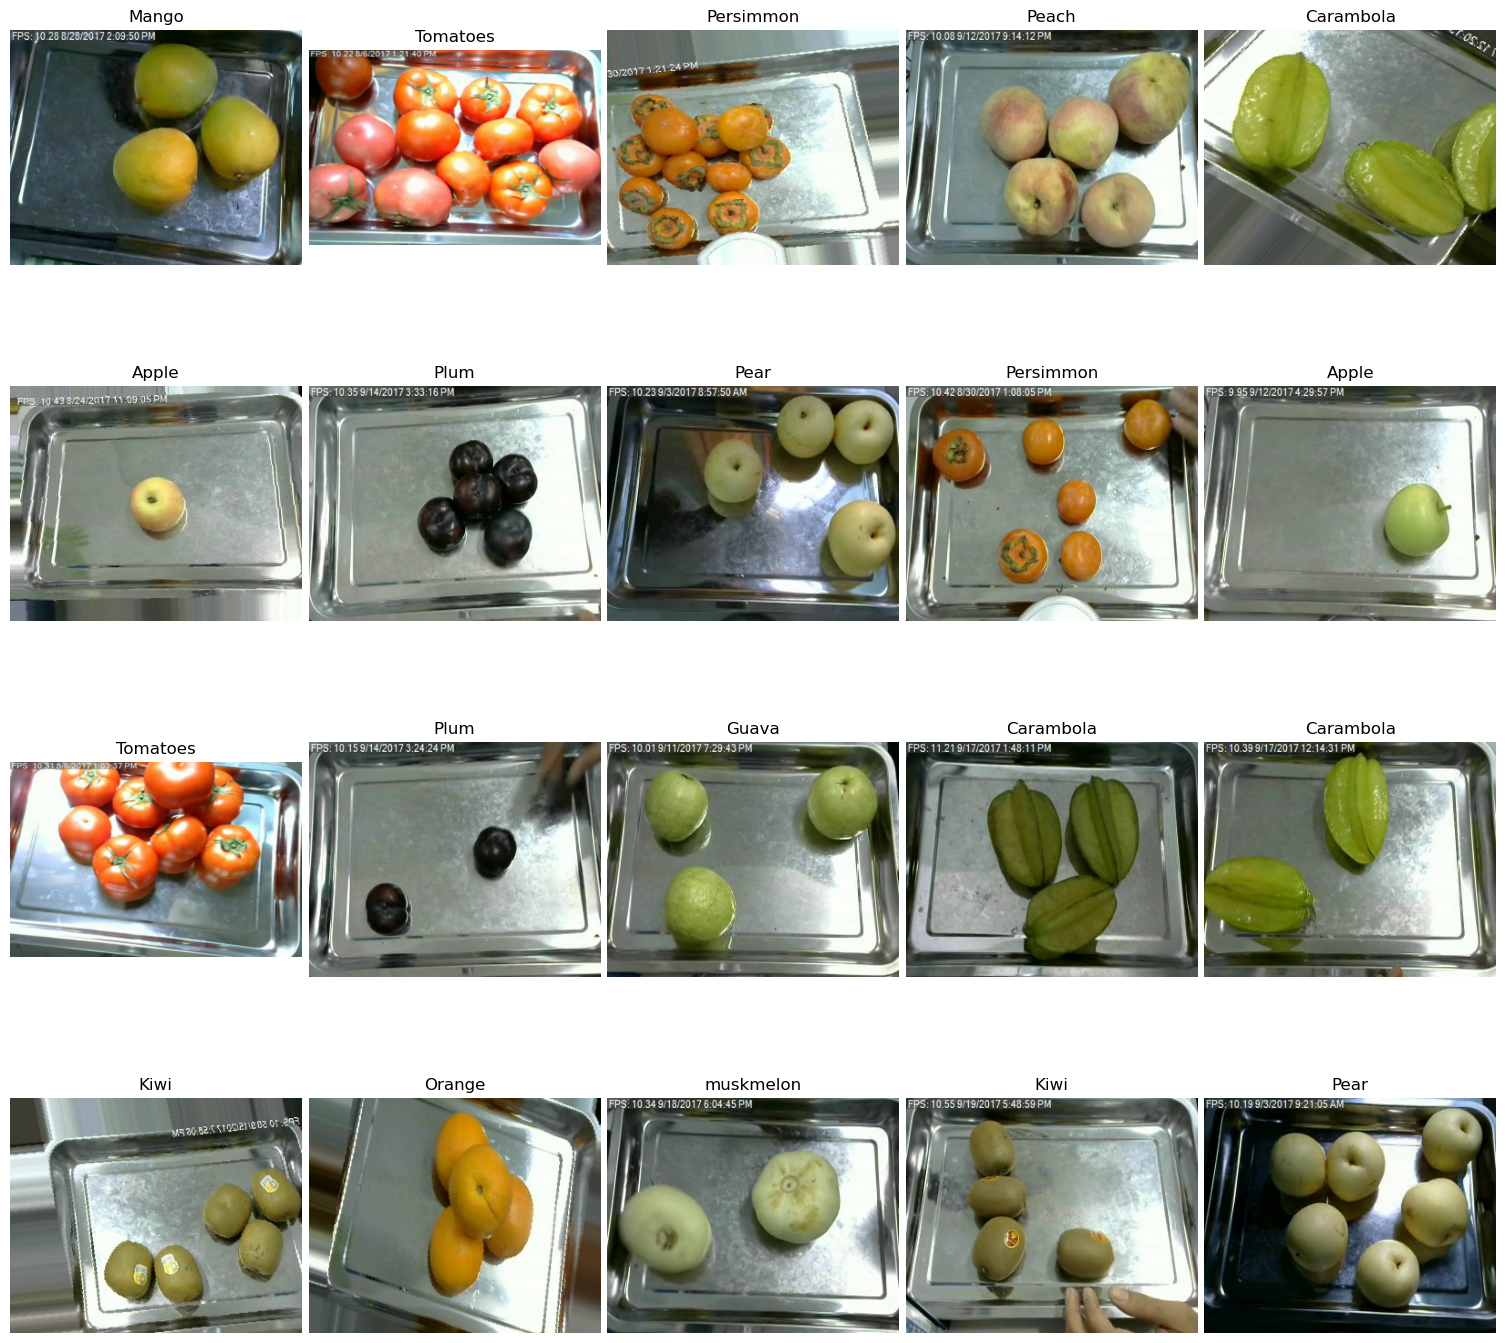

In [6]:
num_rows = 4
num_cols = 5
total_images = num_rows * num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
axes = axes.flatten()

for i, (_, row) in enumerate(df_s.head(total_images).iterrows()):
    img = mpimg.imread(row['path'])
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(row['fruit'], fontsize=12)
    ax.axis('off')  
    if i == total_images - 1:
        break

plt.tight_layout(pad=0.5)
plt.show()

# X, y transformation

In [6]:
size = (50, 50)
images = [resize(plt.imread(path), size) for path in df_s['path']]

X = np.stack(images)
y = df_s['fruit'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train/255.0
X_test = X_test/255.0

In [9]:
nsamples, nx, ny, nrgb = X_train.shape
X_train = X_train.reshape((nsamples, nx*ny*nrgb))

nsamples, nx, ny, nrgb = X_test.shape
X_test = X_test.reshape((nsamples, nx*ny*nrgb))

le = LabelEncoder()
y_train_l = le.fit_transform(y_train)
y_test_l = le.fit_transform(y_test)

In [10]:
pca = PCA(0.8)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Random Forest

In [12]:
# Entrenamos X sin cambios

tuned_parameters = [{'n_estimators': range(1, 100, 2)}]
nfold = 5
                     
start_time = time.time()
rf_CV  = GridSearchCV(RandomForestClassifier(random_state=42), tuned_parameters, cv=nfold, 
                      verbose=2).fit(X_train, y_train_l)
                     
end_time = time.time()
training_time = end_time - start_time
training_minutes, training_seconds = divmod(training_time, 60)
print("Training time:", "{:.0f} minutes {:.0f} seconds".format(training_minutes, training_seconds))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END .....................................n_estimators=1; total time=   1.5s
[CV] END .....................................n_estimators=1; total time=   1.4s
[CV] END .....................................n_estimators=1; total time=   1.3s
[CV] END .....................................n_estimators=1; total time=   1.4s
[CV] END .....................................n_estimators=1; total time=   1.5s
[CV] END .....................................n_estimators=3; total time=   4.1s
[CV] END .....................................n_estimators=3; total time=   4.2s
[CV] END .....................................n_estimators=3; total time=   4.1s
[CV] END .....................................n_estimators=3; total time=   4.2s
[CV] END .....................................n_estimators=3; total time=   4.0s
[CV] END .....................................n_estimators=5; total time=   6.8s
[CV] END .....................................n

[CV] END ....................................n_estimators=41; total time=  54.1s
[CV] END ....................................n_estimators=41; total time=  54.4s
[CV] END ....................................n_estimators=41; total time=  54.5s
[CV] END ....................................n_estimators=41; total time=  54.1s
[CV] END ....................................n_estimators=43; total time=  57.2s
[CV] END ....................................n_estimators=43; total time=  56.6s
[CV] END ....................................n_estimators=43; total time=  57.0s
[CV] END ....................................n_estimators=43; total time=  57.5s
[CV] END ....................................n_estimators=43; total time=  57.0s
[CV] END ....................................n_estimators=45; total time= 1.0min
[CV] END ....................................n_estimators=45; total time=  59.9s
[CV] END ....................................n_estimators=45; total time= 1.1min
[CV] END ...................

[CV] END ....................................n_estimators=81; total time= 1.8min
[CV] END ....................................n_estimators=81; total time= 1.8min
[CV] END ....................................n_estimators=83; total time= 1.8min
[CV] END ....................................n_estimators=83; total time= 1.8min
[CV] END ....................................n_estimators=83; total time= 1.8min
[CV] END ....................................n_estimators=83; total time= 1.8min
[CV] END ....................................n_estimators=83; total time= 1.8min
[CV] END ....................................n_estimators=85; total time= 1.9min
[CV] END ....................................n_estimators=85; total time= 1.9min
[CV] END ....................................n_estimators=85; total time= 1.9min
[CV] END ....................................n_estimators=85; total time= 1.9min
[CV] END ....................................n_estimators=85; total time= 1.9min
[CV] END ...................

In [13]:
n_trees = rf_CV.best_estimator_.n_estimators

print("Number of trees: ", n_trees)

Number of trees:  93


Accuracy:  0.8515
Precision (PPV):  0.8594188713155776
Recall (TPR):  0.8515
F-1 Score:  0.8537687046082701
Matthews Correlation Coefficient (MCC):  0.8411150628726485


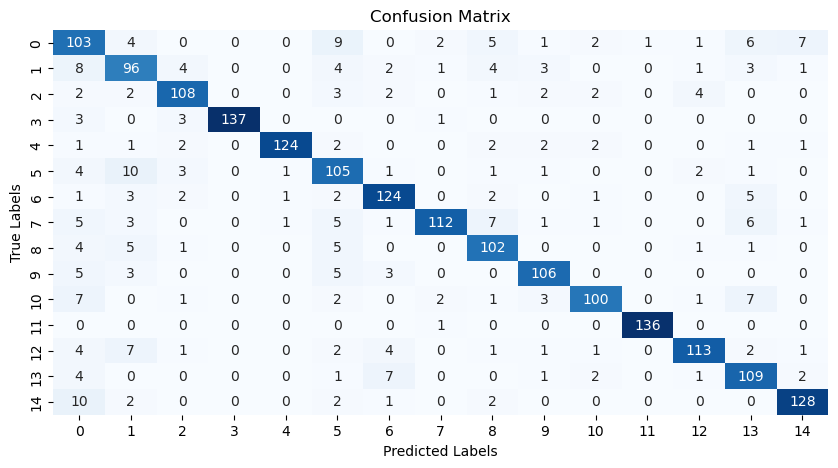

In [38]:
y_pred = rf_CV.predict(X_test)

accuracy = accuracy_score(y_test_l, y_pred)
mcc = matthews_corrcoef(y_test_l, y_pred)
pres = precision_score(y_test_l, y_pred, average='weighted')
recall = recall_score(y_test_l, y_pred, average='weighted')
f1 = f1_score(y_test_l, y_pred, average='weighted')
cm = confusion_matrix(y_test_l, y_pred)

print("Accuracy: ", accuracy)
print("Precision (PPV): ", pres)
print("Recall (TPR): ", recall)
print("F-1 Score: ", f1)
print("Matthews Correlation Coefficient (MCC): ", mcc)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [13]:
# Entrenamos X con PCA

tuned_parameters = [{'n_estimators': range(1, 100, 2)}]
nfold = 5
                     
start_time = time.time()
rf_CV_pca  = GridSearchCV(RandomForestClassifier(random_state=42), tuned_parameters, cv=nfold, 
                      verbose=2).fit(X_train_pca, y_train_l)
                     
end_time = time.time()
training_time = end_time - start_time
training_minutes, training_seconds = divmod(training_time, 60)
print("Training time:", "{:.0f} minutes {:.0f} seconds".format(training_minutes, training_seconds))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=3; total time=   0.3s
[CV] END .....................................n_estimators=3; total time=   0.3s
[CV] END .....................................n_estimators=3; total time=   0.4s
[CV] END .....................................n_estimators=3; total time=   0.3s
[CV] END .....................................n_estimators=3; total time=   0.3s
[CV] END .....................................n_estimators=5; total time=   0.7s
[CV] END .....................................n

[CV] END ....................................n_estimators=41; total time=   5.3s
[CV] END ....................................n_estimators=41; total time=   5.3s
[CV] END ....................................n_estimators=41; total time=   5.3s
[CV] END ....................................n_estimators=41; total time=   5.4s
[CV] END ....................................n_estimators=43; total time=   7.2s
[CV] END ....................................n_estimators=43; total time=   6.4s
[CV] END ....................................n_estimators=43; total time=   6.8s
[CV] END ....................................n_estimators=43; total time=   6.2s
[CV] END ....................................n_estimators=43; total time=   5.6s
[CV] END ....................................n_estimators=45; total time=   6.4s
[CV] END ....................................n_estimators=45; total time=   6.1s
[CV] END ....................................n_estimators=45; total time=   5.9s
[CV] END ...................

[CV] END ....................................n_estimators=81; total time=  12.4s
[CV] END ....................................n_estimators=81; total time=  12.6s
[CV] END ....................................n_estimators=83; total time=  12.4s
[CV] END ....................................n_estimators=83; total time=  12.2s
[CV] END ....................................n_estimators=83; total time=  13.9s
[CV] END ....................................n_estimators=83; total time=  13.7s
[CV] END ....................................n_estimators=83; total time=  14.2s
[CV] END ....................................n_estimators=85; total time=  13.9s
[CV] END ....................................n_estimators=85; total time=  12.9s
[CV] END ....................................n_estimators=85; total time=  15.1s
[CV] END ....................................n_estimators=85; total time=  11.3s
[CV] END ....................................n_estimators=85; total time=  11.4s
[CV] END ...................

In [14]:
n_trees = rf_CV_pca.best_estimator_.n_estimators

print("Number of trees: ", n_trees)

Number of trees:  99


In [19]:
y_pred = rf_CV_pca.predict(X_test_pca)

accuracy = accuracy_score(y_test_l, y_pred)
error_rate = 1 - accuracy
precision = precision_score(y_test_l, y_pred, average='weighted')
recall = recall_score(y_test_l, y_pred, average='weighted')
f1 = f1_score(y_test_l, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test_l, y_pred)

print("Accuracy: ", accuracy)
print("Error Rate: ", error_rate)
print("Precision (PPV): ", precision)
print("Recall (TPR): ", recall)
print("F-1 Score: ", f1)
print("Matthews Correlation Coefficient (MCC): ", mcc)


Accuracy:  0.773
Error Rate:  0.22699999999999998
Precision (PPV):  0.779127648369412
Recall (TPR):  0.773
F-1 Score:  0.7734638216044825
Matthews Correlation Coefficient (MCC):  0.7571227522549622


# X and y

In [6]:
# Vamos a coger la misma cantidad de entradas de cada tipo de fruta
# y entrenaremos los modelos en este dataset, utilizando PCA
# ya que de otra manera el tiempo de entrenamiento es muy elevado

min_count = df['fruit'].value_counts().min()
total_samples = min_count * len(df['fruit'].unique())

df_s = pd.DataFrame()

for fruit, count in df['fruit'].value_counts().items():
    sampled_data = df[df['fruit'] == fruit].sample(min_count, random_state=42)
    df_s = pd.concat([df_s, sampled_data])

df_s.reset_index(inplace=True)

In [7]:
print(df_s.shape[0])
df_s['fruit'].value_counts()

31080


fruit
Guava          2072
Apple          2072
Kiwi           2072
Mango          2072
Banana         2072
Orange         2072
Pear           2072
Peach          2072
Pitaya         2072
Plum           2072
Tomatoes       2072
Pomegranate    2072
Carambola      2072
muskmelon      2072
Persimmon      2072
Name: count, dtype: int64

In [8]:
size = (50, 50)
images = [resize(plt.imread(path), size) for path in df_s['path']]

In [9]:
X = np.stack(images)
y = df_s['fruit'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train/255.0
X_test = X_test/255.0

nsamples, nx, ny, nrgb = X_train.shape
X_train = X_train.reshape((nsamples, nx*ny*nrgb))

nsamples, nx, ny, nrgb = X_test.shape
X_test = X_test.reshape((nsamples, nx*ny*nrgb))

le = LabelEncoder()
y_train_l = le.fit_transform(y_train)
y_test_l = le.fit_transform(y_test)

pca = PCA(0.8)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Random Forest

In [16]:
rf_CV  = RandomForestClassifier(119, random_state=42).fit(X_train_pca, y_train_l)

In [9]:
tuned_parameters = [{'n_estimators': range(1, 120, 2)}]
nfold = 5
                     
start_time = time.time()
rf_CV_pca  = GridSearchCV(RandomForestClassifier(random_state=42), tuned_parameters, cv=nfold, 
                      verbose=2).fit(X_train_pca, y_train_l)
                     
end_time = time.time()
training_time = end_time - start_time
training_minutes, training_seconds = divmod(training_time, 60)
print("Training time:", "{:.0f} minutes {:.0f} seconds".format(training_minutes, training_seconds))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END .....................................n_estimators=1; total time=   0.7s
[CV] END .....................................n_estimators=1; total time=   0.7s
[CV] END .....................................n_estimators=1; total time=   0.7s
[CV] END .....................................n_estimators=1; total time=   0.6s
[CV] END .....................................n_estimators=1; total time=   0.6s
[CV] END .....................................n_estimators=3; total time=   1.9s
[CV] END .....................................n_estimators=3; total time=   1.9s
[CV] END .....................................n_estimators=3; total time=   2.1s
[CV] END .....................................n_estimators=3; total time=   2.3s
[CV] END .....................................n_estimators=3; total time=   2.2s
[CV] END .....................................n_estimators=5; total time=   3.6s
[CV] END .....................................n

[CV] END ....................................n_estimators=41; total time=  29.6s
[CV] END ....................................n_estimators=41; total time=  29.0s
[CV] END ....................................n_estimators=41; total time=  30.2s
[CV] END ....................................n_estimators=41; total time=  28.3s
[CV] END ....................................n_estimators=43; total time=  30.2s
[CV] END ....................................n_estimators=43; total time=  30.4s
[CV] END ....................................n_estimators=43; total time=  31.7s
[CV] END ....................................n_estimators=43; total time=  30.7s
[CV] END ....................................n_estimators=43; total time=  31.6s
[CV] END ....................................n_estimators=45; total time=  32.1s
[CV] END ....................................n_estimators=45; total time=  33.3s
[CV] END ....................................n_estimators=45; total time=  33.2s
[CV] END ...................

[CV] END ....................................n_estimators=81; total time=  20.2s
[CV] END ....................................n_estimators=81; total time=  31.4s
[CV] END ....................................n_estimators=83; total time=  56.3s
[CV] END ....................................n_estimators=83; total time=  30.2s
[CV] END ....................................n_estimators=83; total time=  20.6s
[CV] END ....................................n_estimators=83; total time=  19.9s
[CV] END ....................................n_estimators=83; total time=  20.3s
[CV] END ....................................n_estimators=85; total time=  21.3s
[CV] END ....................................n_estimators=85; total time=  19.8s
[CV] END ....................................n_estimators=85; total time=  22.1s
[CV] END ....................................n_estimators=85; total time=  20.6s
[CV] END ....................................n_estimators=85; total time=  23.5s
[CV] END ...................

In [10]:
n_trees = rf_CV_pca.best_estimator_.n_estimators
y_pred = rf_CV_pca.predict(X_test_pca)

accuracy = accuracy_score(y_test_l, y_pred)
precision = precision_score(y_test_l, y_pred, average='weighted')
recall = recall_score(y_test_l, y_pred, average='weighted')
f1 = f1_score(y_test_l, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test_l, y_pred)

print("Number of trees: ", n_trees)
print("Accuracy: ", accuracy)
print("Precision (PPV): ", precision)
print("Recall (TPR): ", recall)
print("F-1 Score: ", f1)
print("Matthews Correlation Coefficient (MCC): ", mcc)

Number of trees:  119
Accuracy:  0.8381595881595881
Precision (PPV):  0.8397419554793467
Recall (TPR):  0.8381595881595881
F-1 Score:  0.8378811114430966
Matthews Correlation Coefficient (MCC):  0.8267554618554716


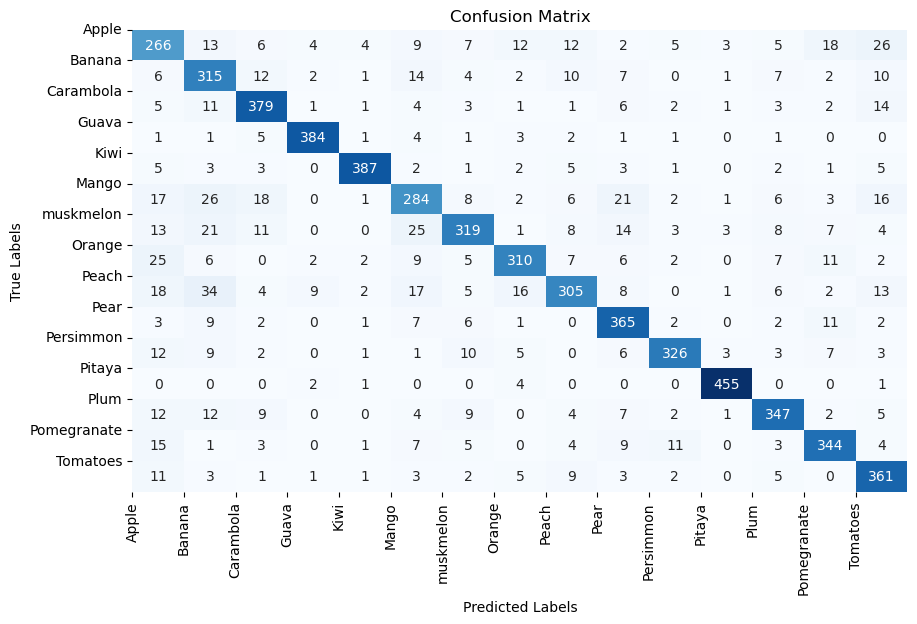

In [18]:
original_labels = df['fruit'].unique()
cm = confusion_matrix(y_test_l, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# KNN

In [12]:
k_max =20
rang_K = np.arange(1, k_max+1)
tuned_parameters = [{'n_neighbors': rang_K}]
nfold = 5

start_time = time.time()
neigh_CV = GridSearchCV(KNeighborsClassifier(), tuned_parameters, 
                        cv=nfold, verbose=2).fit(X_train_pca, y_train_l)
end_time = time.time()
training_time = end_time - start_time
training_minutes, training_seconds = divmod(training_time, 60)
print("Training time:", "{:.0f} minutes {:.0f} seconds".format(training_minutes, training_seconds))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ......................................n_neighbors=1; total time=   3.9s
[CV] END ......................................n_neighbors=1; total time=   2.6s
[CV] END ......................................n_neighbors=1; total time=   2.7s
[CV] END ......................................n_neighbors=1; total time=   2.6s
[CV] END ......................................n_neighbors=1; total time=   2.5s
[CV] END ......................................n_neighbors=2; total time=   2.3s
[CV] END ......................................n_neighbors=2; total time=   2.3s
[CV] END ......................................n_neighbors=2; total time=   2.0s
[CV] END ......................................n_neighbors=2; total time=   2.3s
[CV] END ......................................n_neighbors=2; total time=   2.2s
[CV] END ......................................n_neighbors=3; total time=   2.3s
[CV] END ......................................

In [14]:
y_pred = neigh_CV.predict(X_test_pca) 
K_CV = neigh_CV.best_params_['n_neighbors']

accuracy = accuracy_score(y_test_l, y_pred)
precision = precision_score(y_test_l, y_pred, average='weighted')
recall = recall_score(y_test_l, y_pred, average='weighted')
f1 = f1_score(y_test_l, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test_l, y_pred)

print("Neighbors: ", K_CV)
print("Accuracy: ", accuracy)
print("Precision (PPV): ", precision)
print("Recall (TPR): ", recall)
print("F-1 Score: ", f1)
print("Matthews Correlation Coefficient (MCC): ", mcc)

Neighbors:  1
Accuracy:  0.8719433719433719
Precision (PPV):  0.8746847939960611
Recall (TPR):  0.8719433719433719
F-1 Score:  0.8716327819723938
Matthews Correlation Coefficient (MCC):  0.8630126334500067


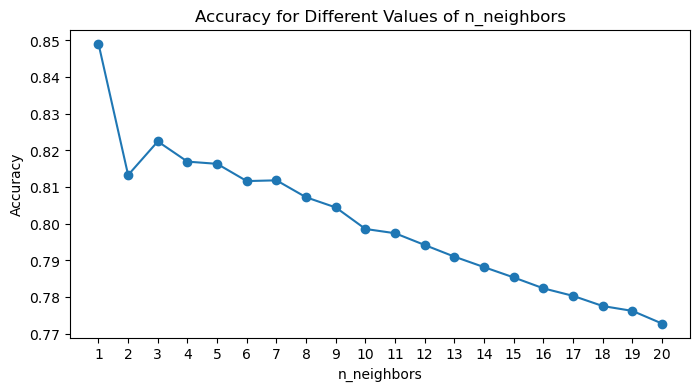

In [17]:
mean_test_scores = neigh_CV.cv_results_['mean_test_score']
params = neigh_CV.cv_results_['params']

n_neighbors_values = [params[i]['n_neighbors'] for i in range(len(params))]

plt.figure(figsize=(8, 4))
plt.plot(n_neighbors_values, mean_test_scores, marker='o')
plt.title('Accuracy for Different Values of n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.xticks(n_neighbors_values)
plt.show()


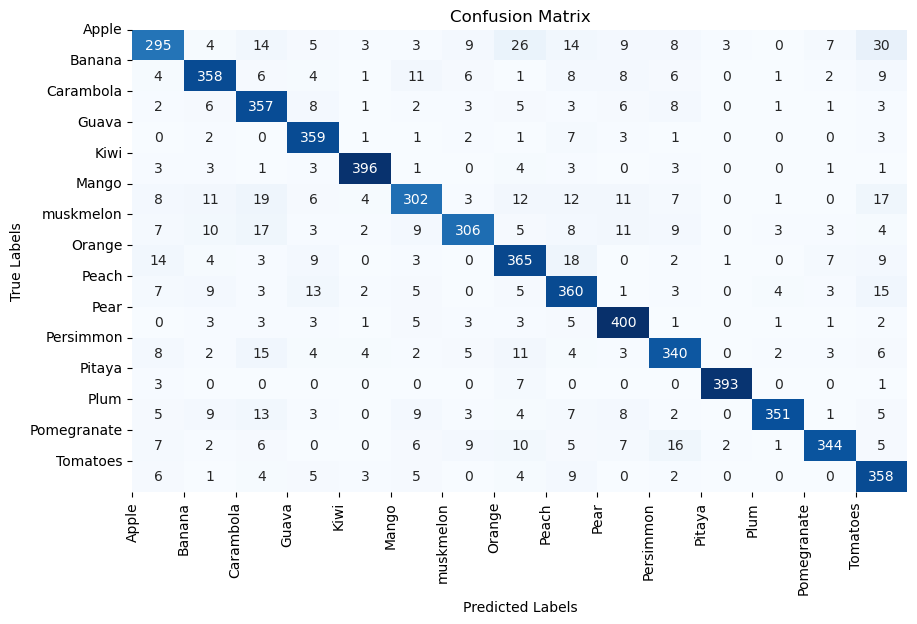

In [18]:
original_labels = df['fruit'].unique()
cm = confusion_matrix(y_test_l, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Ridge

In [15]:
rang_alpha = np.logspace(-3, 1, 100)
tuned_parameters = [{'alpha': rang_alpha}]
nfold = 5

start_time = time.time()

ridge_CV = GridSearchCV(RidgeClassifier(), tuned_parameters, cv=nfold, 
                        verbose=2).fit(X_train_pca, y_train_l)
end_time = time.time()
training_time = end_time - start_time
training_minutes, training_seconds = divmod(training_time, 60)
print("Training time:", "{:.0f} minutes {:.0f} seconds".format(training_minutes, training_seconds))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ........................................alpha=0.001; total time=   0.2s
[CV] END ........................................alpha=0.001; total time=   0.1s
[CV] END ........................................alpha=0.001; total time=   0.1s
[CV] END ........................................alpha=0.001; total time=   0.1s
[CV] END ........................................alpha=0.001; total time=   0.2s
[CV] END ........................alpha=0.0010974987654930556; total time=   0.1s
[CV] END ........................alpha=0.0010974987654930556; total time=   0.1s
[CV] END ........................alpha=0.0010974987654930556; total time=   0.1s
[CV] END ........................alpha=0.0010974987654930556; total time=   0.1s
[CV] END ........................alpha=0.0010974987654930556; total time=   0.1s
[CV] END ........................alpha=0.0012045035402587824; total time=   0.0s
[CV] END ........................alpha=0.00120

[CV] END .........................alpha=0.006428073117284319; total time=   0.1s
[CV] END .........................alpha=0.006428073117284319; total time=   0.1s
[CV] END .........................alpha=0.006428073117284319; total time=   0.2s
[CV] END .........................alpha=0.006428073117284319; total time=   0.0s
[CV] END .........................alpha=0.007054802310718645; total time=   0.1s
[CV] END .........................alpha=0.007054802310718645; total time=   0.1s
[CV] END .........................alpha=0.007054802310718645; total time=   0.1s
[CV] END .........................alpha=0.007054802310718645; total time=   0.1s
[CV] END .........................alpha=0.007054802310718645; total time=   0.1s
[CV] END .........................alpha=0.007742636826811269; total time=   0.1s
[CV] END .........................alpha=0.007742636826811269; total time=   0.0s
[CV] END .........................alpha=0.007742636826811269; total time=   0.1s
[CV] END ...................

[CV] END ..........................alpha=0.04132012400115339; total time=   0.1s
[CV] END ..........................alpha=0.04132012400115339; total time=   0.1s
[CV] END ..........................alpha=0.04534878508128584; total time=   0.1s
[CV] END ..........................alpha=0.04534878508128584; total time=   0.1s
[CV] END ..........................alpha=0.04534878508128584; total time=   0.1s
[CV] END ..........................alpha=0.04534878508128584; total time=   0.1s
[CV] END ..........................alpha=0.04534878508128584; total time=   0.1s
[CV] END .........................alpha=0.049770235643321115; total time=   0.1s
[CV] END .........................alpha=0.049770235643321115; total time=   0.2s
[CV] END .........................alpha=0.049770235643321115; total time=   0.1s
[CV] END .........................alpha=0.049770235643321115; total time=   0.1s
[CV] END .........................alpha=0.049770235643321115; total time=   0.1s
[CV] END ...................

[CV] END ..........................alpha=0.29150530628251786; total time=   0.1s
[CV] END ..........................alpha=0.29150530628251786; total time=   0.1s
[CV] END ..........................alpha=0.29150530628251786; total time=   0.1s
[CV] END ..........................alpha=0.29150530628251786; total time=   0.1s
[CV] END ..........................alpha=0.31992671377973847; total time=   0.1s
[CV] END ..........................alpha=0.31992671377973847; total time=   0.1s
[CV] END ..........................alpha=0.31992671377973847; total time=   0.1s
[CV] END ..........................alpha=0.31992671377973847; total time=   0.1s
[CV] END ..........................alpha=0.31992671377973847; total time=   0.0s
[CV] END ..........................alpha=0.35111917342151344; total time=   0.1s
[CV] END ..........................alpha=0.35111917342151344; total time=   0.1s
[CV] END ..........................alpha=0.35111917342151344; total time=   0.2s
[CV] END ...................

[CV] END ............................alpha=1.873817422860385; total time=   0.1s
[CV] END ............................alpha=1.873817422860385; total time=   0.1s
[CV] END ...........................alpha=2.0565123083486534; total time=   0.1s
[CV] END ...........................alpha=2.0565123083486534; total time=   0.2s
[CV] END ...........................alpha=2.0565123083486534; total time=   0.1s
[CV] END ...........................alpha=2.0565123083486534; total time=   0.1s
[CV] END ...........................alpha=2.0565123083486534; total time=   0.1s
[CV] END ...........................alpha=2.2570197196339215; total time=   0.1s
[CV] END ...........................alpha=2.2570197196339215; total time=   0.1s
[CV] END ...........................alpha=2.2570197196339215; total time=   0.1s
[CV] END ...........................alpha=2.2570197196339215; total time=   0.1s
[CV] END ...........................alpha=2.2570197196339215; total time=   0.1s
[CV] END ...................

In [16]:
y_pred = ridge_CV.predict(X_test_pca) 
alpha_CV = ridge_CV.best_params_['alpha']

accuracy = accuracy_score(y_test_l, y_pred)
precision = precision_score(y_test_l, y_pred, average='weighted')
recall = recall_score(y_test_l, y_pred, average='weighted')
f1 = f1_score(y_test_l, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test_l, y_pred)

print('Selected value of alpha: ' + str(alpha_CV))
print('Accuracy: ' + str(accuracy))
print("Precision (PPV): ", precision)
print("Recall (TPR): ", recall)
print("F-1 Score: ", f1)
print("Matthews Correlation Coefficient (MCC): ", mcc)

Selected value of alpha: 0.0015922827933410922
Accuracy: 0.6793758043758044
Precision (PPV):  0.6791049543458829
Recall (TPR):  0.6793758043758044
F-1 Score:  0.6638137418495271
Matthews Correlation Coefficient (MCC):  0.6583497112203205


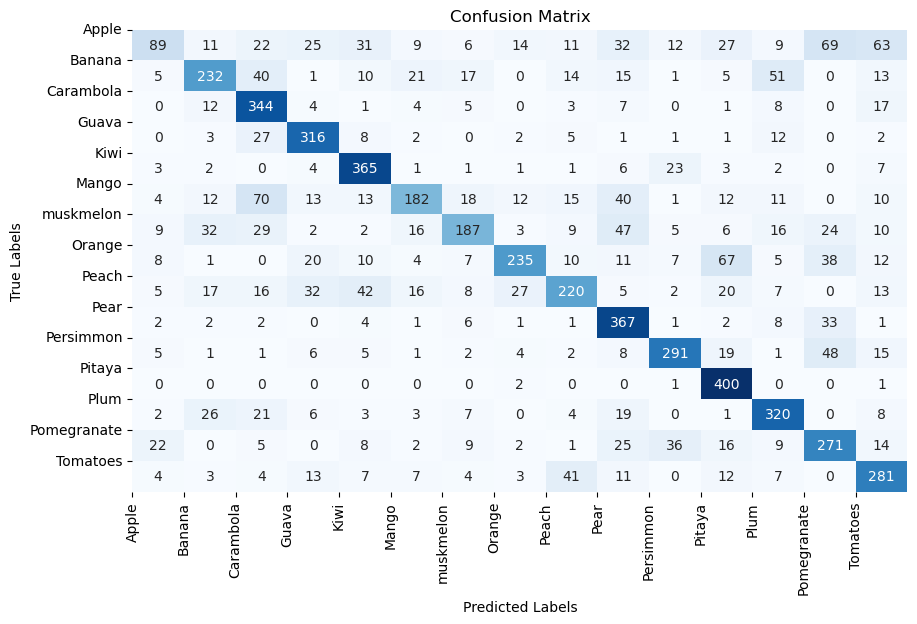

In [21]:
original_labels = df['fruit'].unique()
cm = confusion_matrix(y_test_l, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# SGDClassifier

In [17]:
range_alpha = np.logspace(-3, 1, 10)
range_eta0 = np.logspace(-3, 1, 10)
tuned_parameters = [{"alpha" : range_alpha, "eta0" : range_eta0}]
nfold = 3

start_time = time.time()
sgd_CV = GridSearchCV(SGDClassifier(early_stopping=True), tuned_parameters, cv = nfold,
                     verbose=2).fit(X_train_pca, y_train_l)
end_time = time.time()
training_time = end_time - start_time
training_minutes, training_seconds = divmod(training_time, 60)
print("Training time:", "{:.0f} minutes {:.0f} seconds".format(training_minutes, training_seconds))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ............................alpha=0.001, eta0=0.001; total time=   1.3s
[CV] END ............................alpha=0.001, eta0=0.001; total time=   1.0s
[CV] END ............................alpha=0.001, eta0=0.001; total time=   1.3s
[CV] END ............alpha=0.001, eta0=0.0027825594022071257; total time=   1.3s
[CV] END ............alpha=0.001, eta0=0.0027825594022071257; total time=   1.1s
[CV] END ............alpha=0.001, eta0=0.0027825594022071257; total time=   1.3s
[CV] END .............alpha=0.001, eta0=0.007742636826811269; total time=   1.3s
[CV] END .............alpha=0.001, eta0=0.007742636826811269; total time=   1.1s
[CV] END .............alpha=0.001, eta0=0.007742636826811269; total time=   1.2s
[CV] END .............alpha=0.001, eta0=0.021544346900318832; total time=   1.2s
[CV] END .............alpha=0.001, eta0=0.021544346900318832; total time=   1.2s
[CV] END .............alpha=0.001, eta0=0.0215

[CV] END alpha=0.021544346900318832, eta0=0.021544346900318832; total time=   1.7s
[CV] END alpha=0.021544346900318832, eta0=0.021544346900318832; total time=   1.8s
[CV] END alpha=0.021544346900318832, eta0=0.05994842503189409; total time=   1.5s
[CV] END alpha=0.021544346900318832, eta0=0.05994842503189409; total time=   1.6s
[CV] END alpha=0.021544346900318832, eta0=0.05994842503189409; total time=   1.6s
[CV] END alpha=0.021544346900318832, eta0=0.1668100537200059; total time=   1.6s
[CV] END alpha=0.021544346900318832, eta0=0.1668100537200059; total time=   1.2s
[CV] END alpha=0.021544346900318832, eta0=0.1668100537200059; total time=   1.2s
[CV] END alpha=0.021544346900318832, eta0=0.46415888336127775; total time=   1.3s
[CV] END alpha=0.021544346900318832, eta0=0.46415888336127775; total time=   1.2s
[CV] END alpha=0.021544346900318832, eta0=0.46415888336127775; total time=   1.4s
[CV] END alpha=0.021544346900318832, eta0=1.2915496650148828; total time=   1.6s
[CV] END alpha=0.0

[CV] END .alpha=0.46415888336127775, eta0=1.2915496650148828; total time=   1.5s
[CV] END .alpha=0.46415888336127775, eta0=1.2915496650148828; total time=   1.6s
[CV] END .alpha=0.46415888336127775, eta0=1.2915496650148828; total time=   2.0s
[CV] END ..alpha=0.46415888336127775, eta0=3.593813663804626; total time=   1.9s
[CV] END ..alpha=0.46415888336127775, eta0=3.593813663804626; total time=   1.9s
[CV] END ..alpha=0.46415888336127775, eta0=3.593813663804626; total time=   1.5s
[CV] END ...............alpha=0.46415888336127775, eta0=10.0; total time=   1.6s
[CV] END ...............alpha=0.46415888336127775, eta0=10.0; total time=   1.5s
[CV] END ...............alpha=0.46415888336127775, eta0=10.0; total time=   1.3s
[CV] END ...............alpha=1.2915496650148828, eta0=0.001; total time=   2.5s
[CV] END ...............alpha=1.2915496650148828, eta0=0.001; total time=   2.0s
[CV] END ...............alpha=1.2915496650148828, eta0=0.001; total time=   1.7s
[CV] END alpha=1.29154966501

In [19]:
y_pred = sgd_CV.predict(X_test_pca) 
alpha_CV = sgd_CV.best_params_['alpha']
eta0_CV = sgd_CV.best_params_['eta0']

accuracy = accuracy_score(y_test_l, y_pred)
precision = precision_score(y_test_l, y_pred, average='weighted')
recall = recall_score(y_test_l, y_pred, average='weighted')
f1 = f1_score(y_test_l, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test_l, y_pred)

print('Selected value of alpha: ' + str(alpha_CV))
print('Selected value of eta0: ' + str(eta0_CV))
print('Accuracy: ' + str(accuracy))
print("Precision (PPV): ", precision)
print("Recall (TPR): ", recall)
print("F-1 Score: ", f1)
print("Matthews Correlation Coefficient (MCC): ", mcc)

Selected value of alpha: 1.2915496650148828
Selected value of eta0: 3.593813663804626
Accuracy: 0.4343629343629344
Precision (PPV):  0.6757950824382694
Recall (TPR):  0.4343629343629344
F-1 Score:  0.43885514395768954
Matthews Correlation Coefficient (MCC):  0.42693784299629256


C:\Users\ginge\anaconda3\envs\mldl\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# BaggingClassifier

In [45]:
rang_n_trees = np.arange(1, 100, 5)
tuned_parameters = [{'n_estimators': rang_n_trees, 
                    'max_samples': [0.5, 1.0],
                    'max_features': [0.5, 0.75, 1.0]}]
nfold = 3

start_time = time.time()
bagging = GridSearchCV(BaggingClassifier(), tuned_parameters, 
                       cv=nfold, verbose=2).fit(X_train_pca, y_train_l)
end_time = time.time()
training_time = end_time - start_time
training_minutes, training_seconds = divmod(training_time, 60)
print("Training time:", "{:.0f} minutes {:.0f} seconds".format(training_minutes, training_seconds))

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV] END ..max_features=0.5, max_samples=0.5, n_estimators=1; total time=   1.1s
[CV] END ..max_features=0.5, max_samples=0.5, n_estimators=1; total time=   1.0s
[CV] END ..max_features=0.5, max_samples=0.5, n_estimators=1; total time=   1.0s
[CV] END ..max_features=0.5, max_samples=0.5, n_estimators=6; total time=   6.3s
[CV] END ..max_features=0.5, max_samples=0.5, n_estimators=6; total time=   6.1s
[CV] END ..max_features=0.5, max_samples=0.5, n_estimators=6; total time=   6.3s
[CV] END .max_features=0.5, max_samples=0.5, n_estimators=11; total time=  12.1s
[CV] END .max_features=0.5, max_samples=0.5, n_estimators=11; total time=  12.4s
[CV] END .max_features=0.5, max_samples=0.5, n_estimators=11; total time=  13.6s
[CV] END .max_features=0.5, max_samples=0.5, n_estimators=16; total time=  18.8s
[CV] END .max_features=0.5, max_samples=0.5, n_estimators=16; total time=  20.2s
[CV] END .max_features=0.5, max_samples=0.5, n

[CV] END .max_features=0.5, max_samples=1.0, n_estimators=66; total time= 2.1min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=71; total time= 2.2min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=71; total time= 2.2min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=71; total time= 2.2min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=76; total time= 2.4min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=76; total time= 2.5min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=76; total time= 2.4min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=81; total time= 2.7min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=81; total time= 2.7min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=81; total time= 2.8min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=86; total time= 2.7min
[CV] END .max_features=0.5, max_samples=1.0, n_estimators=86; total time= 2.5min
[CV] END .max_features=0.5, 

[CV] END max_features=0.75, max_samples=1.0, n_estimators=36; total time= 1.8min
[CV] END max_features=0.75, max_samples=1.0, n_estimators=41; total time= 2.1min
[CV] END max_features=0.75, max_samples=1.0, n_estimators=41; total time= 2.1min
[CV] END max_features=0.75, max_samples=1.0, n_estimators=41; total time= 2.2min
[CV] END max_features=0.75, max_samples=1.0, n_estimators=46; total time= 2.3min
[CV] END max_features=0.75, max_samples=1.0, n_estimators=46; total time= 2.3min
[CV] END max_features=0.75, max_samples=1.0, n_estimators=46; total time= 2.4min
[CV] END max_features=0.75, max_samples=1.0, n_estimators=51; total time= 2.7min
[CV] END max_features=0.75, max_samples=1.0, n_estimators=51; total time= 2.7min
[CV] END max_features=0.75, max_samples=1.0, n_estimators=51; total time= 2.6min
[CV] END max_features=0.75, max_samples=1.0, n_estimators=56; total time= 2.9min
[CV] END max_features=0.75, max_samples=1.0, n_estimators=56; total time= 2.9min
[CV] END max_features=0.75, 

[CV] END ..max_features=1.0, max_samples=1.0, n_estimators=6; total time=  23.8s
[CV] END .max_features=1.0, max_samples=1.0, n_estimators=11; total time=  45.5s
[CV] END .max_features=1.0, max_samples=1.0, n_estimators=11; total time=  45.4s
[CV] END .max_features=1.0, max_samples=1.0, n_estimators=11; total time=  44.9s
[CV] END .max_features=1.0, max_samples=1.0, n_estimators=16; total time= 1.1min
[CV] END .max_features=1.0, max_samples=1.0, n_estimators=16; total time= 1.1min
[CV] END .max_features=1.0, max_samples=1.0, n_estimators=16; total time= 1.1min
[CV] END .max_features=1.0, max_samples=1.0, n_estimators=21; total time= 1.4min
[CV] END .max_features=1.0, max_samples=1.0, n_estimators=21; total time= 1.5min
[CV] END .max_features=1.0, max_samples=1.0, n_estimators=21; total time= 1.5min
[CV] END .max_features=1.0, max_samples=1.0, n_estimators=26; total time= 1.8min
[CV] END .max_features=1.0, max_samples=1.0, n_estimators=26; total time= 1.8min
[CV] END .max_features=1.0, 

In [48]:
accuracy = bagging.score(X_test_pca, y_test_l)
max_samples = bagging.best_params_['max_samples'] 
max_features = bagging.best_params_['max_features']
n_estimators = bagging.best_params_['n_estimators']

print(f'Accuracy: {accuracy}')
print(f'Max samples: {max_samples}')
print(f'Max features: {max_features}')
print(f'N estimators: {n_estimators}')

Accuracy: 0.8138674388674388
Max samples: 1.0
Max features: 0.5
N estimators: 96


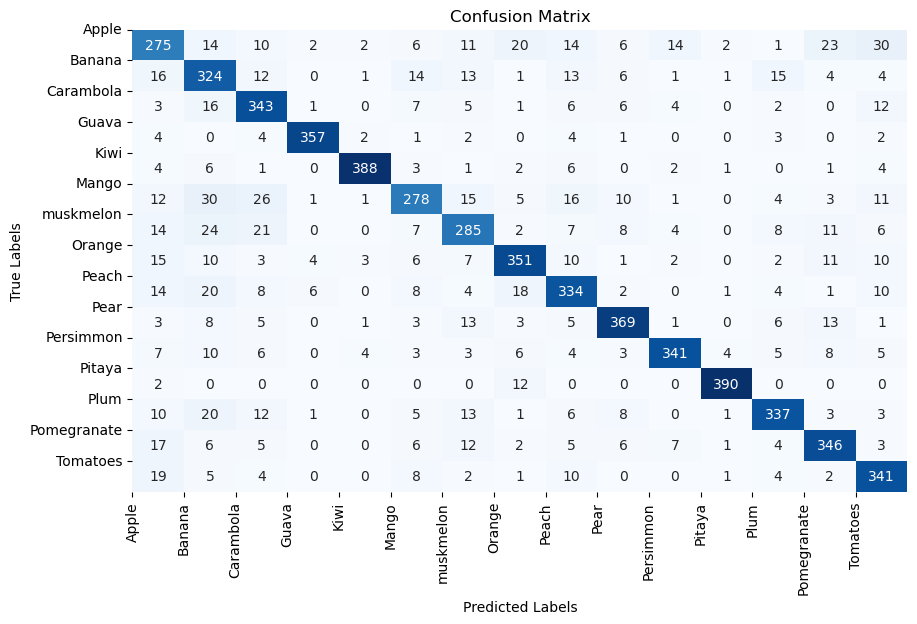

In [49]:
y_pred = bagging.predict(X_test_pca) 

original_labels = df['fruit'].unique()
cm = confusion_matrix(y_test_l, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# AdaBoostClassifier

In [26]:
tuned_parameters = {'base_estimator__max_depth': [1, 2, 3],  
                    'algorithm': ['SAMME', 'SAMME.R'],       
                    'n_estimators': [50, 100, 200]}
nfold = 3
base_learner = DecisionTreeClassifier()

start_time = time.time()
ada_CV = GridSearchCV(AdaBoostClassifier(base_learner), tuned_parameters, cv=nfold,
                     verbose=2).fit(X_train_pca, y_train_l)
end_time = time.time()
training_time = end_time - start_time
training_minutes, training_seconds = divmod(training_time, 60)
print("Training time:", "{:.0f} minutes {:.0f} seconds".format(training_minutes, training_seconds))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=1, n_estimators=50; total time=  22.1s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=1, n_estimators=50; total time=  21.9s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=1, n_estimators=50; total time=  21.8s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=1, n_estimators=100; total time=  45.6s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=1, n_estimators=100; total time=  46.2s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=1, n_estimators=100; total time=  44.2s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=1, n_estimators=200; total time= 1.5min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=1, n_estimators=200; total time= 1.5min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=1, n_estimators=200; total time= 1.5min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=2, n_estimators=50; total time=  42.7s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=2, n_estimators=50; total time=  42.9s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=2, n_estimators=50; total time=  43.2s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=2, n_estimators=100; total time= 1.4min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=2, n_estimators=100; total time= 1.4min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=2, n_estimators=100; total time= 1.6min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=2, n_estimators=200; total time= 2.9min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=2, n_estimators=200; total time= 3.0min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=2, n_estimators=200; total time= 2.9min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=3, n_estimators=50; total time= 1.1min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=3, n_estimators=50; total time= 1.1min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=3, n_estimators=50; total time= 1.1min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=3, n_estimators=100; total time= 2.2min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=3, n_estimators=100; total time= 2.4min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=3, n_estimators=100; total time= 2.2min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=3, n_estimators=200; total time= 4.4min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=3, n_estimators=200; total time= 4.4min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME, base_estimator__max_depth=3, n_estimators=200; total time= 4.4min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=1, n_estimators=50; total time=  22.4s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=1, n_estimators=50; total time=  22.1s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=1, n_estimators=50; total time=  22.0s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=1, n_estimators=100; total time=  44.6s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=1, n_estimators=100; total time=  44.4s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=1, n_estimators=100; total time=  44.3s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=1, n_estimators=200; total time= 1.5min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=1, n_estimators=200; total time= 1.5min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=1, n_estimators=200; total time= 1.5min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=2, n_estimators=50; total time=  43.3s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=2, n_estimators=50; total time=  42.5s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=2, n_estimators=50; total time=  44.3s


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=2, n_estimators=100; total time= 1.5min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=2, n_estimators=100; total time= 1.4min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=2, n_estimators=100; total time= 1.4min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=2, n_estimators=200; total time= 3.0min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=2, n_estimators=200; total time= 3.0min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=2, n_estimators=200; total time= 3.0min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=3, n_estimators=50; total time= 1.1min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=3, n_estimators=50; total time= 1.1min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=3, n_estimators=50; total time= 1.1min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=3, n_estimators=100; total time= 2.2min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=3, n_estimators=100; total time= 2.2min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=3, n_estimators=100; total time= 2.4min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=3, n_estimators=200; total time= 4.4min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=3, n_estimators=200; total time= 4.3min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)


[CV] END algorithm=SAMME.R, base_estimator__max_depth=3, n_estimators=200; total time= 4.5min


C:\Users\ginge\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:929: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


Training time: 99 minutes 50 seconds


In [38]:
accuracy = ada_CV.score(X_test_pca, y_test_l)
algorithm = ada_CV.best_params_['algorithm'] 
max_depth = ada_CV.best_params_['base_estimator__max_depth']
n_estimators = ada_CV.best_params_['n_estimators']

print(f'Accuracy: {accuracy}')
print(f'Algorithm: {algorithm}')
print(f'Max depth: {max_depth}')
print(f'N estimators: {n_estimators}')

Accuracy: 0.5583976833976834
Algorithm: SAMME
Max depth: 3
N estimators: 200


In [21]:
# Usamos None max_depth for DecisionTreeClassifier
base_learner = DecisionTreeClassifier()

start_time = time.time()
ada = AdaBoostClassifier(base_learner, algorithm='SAMME', n_estimators=200).fit(X_train_pca, y_train_l)
end_time = time.time()
training_time = end_time - start_time
training_minutes, training_seconds = divmod(training_time, 60)
print("Training time:", "{:.0f} minutes {:.0f} seconds".format(training_minutes, training_seconds))

Training time: 0 minutes 14 seconds


In [22]:
y_pred = ada.predict(X_test_pca) 

accuracy = accuracy_score(y_test_l, y_pred)
precision = precision_score(y_test_l, y_pred, average='weighted')
recall = recall_score(y_test_l, y_pred, average='weighted')
f1 = f1_score(y_test_l, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test_l, y_pred)

print('Accuracy: ' + str(accuracy))
print("Precision (PPV): ", precision)
print("Recall (TPR): ", recall)
print("F-1 Score: ", f1)
print("Matthews Correlation Coefficient (MCC): ", mcc)

Accuracy: 0.578024453024453
Precision (PPV):  0.5793911994319486
Recall (TPR):  0.578024453024453
F-1 Score:  0.5779032663942284
Matthews Correlation Coefficient (MCC):  0.5479783249653436


# XGBoost

In [8]:
nfold = 3
tuned_parameters = {'max_depth': [None, 1, 2, 3],                  
                    'n_estimators': [50, 100, 200],          
                    'objective': ['multi:softmax', 'multi:softprob']}

start_time = time.time()
xgb_CV = GridSearchCV(XGBClassifier(), tuned_parameters, cv=nfold,
                     verbose=2).fit(X_train_pca, y_train_l)
end_time = time.time()
training_time = end_time - start_time
training_minutes, training_seconds = divmod(training_time, 60)
print("Training time:", "{:.0f} minutes {:.0f} seconds".format(training_minutes, training_seconds))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=None, n_estimators=50, objective=multi:softmax; total time=  46.1s
[CV] END max_depth=None, n_estimators=50, objective=multi:softmax; total time=  43.0s
[CV] END max_depth=None, n_estimators=50, objective=multi:softmax; total time=  52.7s
[CV] END max_depth=None, n_estimators=50, objective=multi:softprob; total time=  52.0s
[CV] END max_depth=None, n_estimators=50, objective=multi:softprob; total time=  51.3s
[CV] END max_depth=None, n_estimators=50, objective=multi:softprob; total time=  50.9s
[CV] END max_depth=None, n_estimators=100, objective=multi:softmax; total time= 1.5min
[CV] END max_depth=None, n_estimators=100, objective=multi:softmax; total time= 1.4min
[CV] END max_depth=None, n_estimators=100, objective=multi:softmax; total time= 1.4min
[CV] END max_depth=None, n_estimators=100, objective=multi:softprob; total time= 1.5min
[CV] END max_depth=None, n_estimators=100, objective=multi:softprob; to

In [9]:
max_depth = xgb_CV.best_params_['max_depth'] 
n_estimators = xgb_CV.best_params_['n_estimators']
objective = xgb_CV.best_params_['objective']

print(f'Max depth: {max_depth}')
print(f'N estimators: {n_estimators}')
print(f'Objective: {objective}')

Accuracy: 0.856016731016731
Max depth: None
N estimators: 200
Objective: multi:softmax


In [24]:
y_pred = xgb_CV.predict(X_test_pca) 

accuracy = accuracy_score(y_test_l, y_pred)
precision = precision_score(y_test_l, y_pred, average='weighted')
recall = recall_score(y_test_l, y_pred, average='weighted')
f1 = f1_score(y_test_l, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test_l, y_pred)

print('Accuracy: ' + str(accuracy))
print("Precision (PPV): ", precision)
print("Recall (TPR): ", recall)
print("F-1 Score: ", f1)
print("Matthews Correlation Coefficient (MCC): ", mcc)

Accuracy: 0.8732303732303732
Precision (PPV):  0.8732502627887048
Recall (TPR):  0.8732303732303732
F-1 Score:  0.8729945606781847
Matthews Correlation Coefficient (MCC):  0.8642048810437254


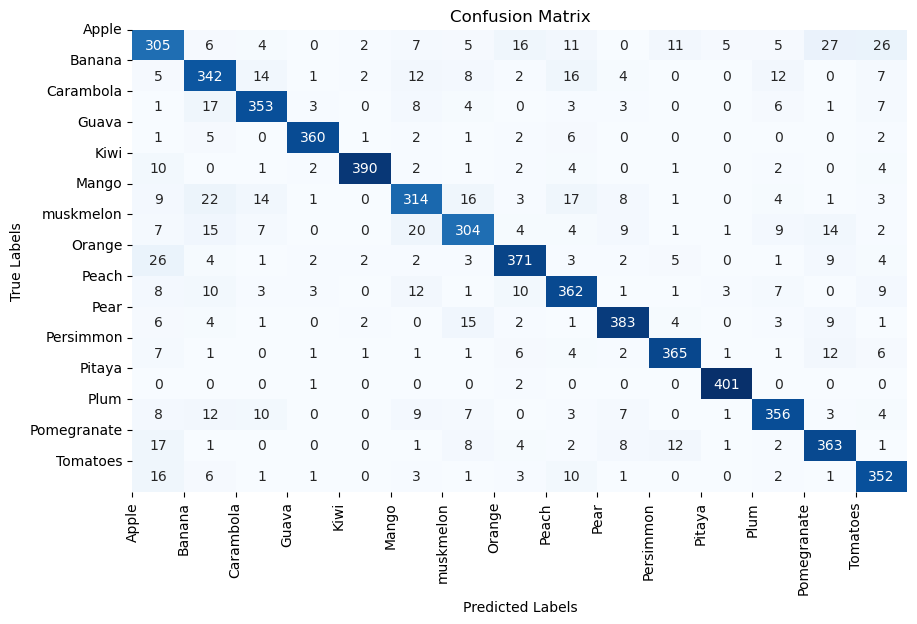

In [10]:
y_pred = xgb_CV.predict(X_test_pca) 

original_labels = df['fruit'].unique()
cm = confusion_matrix(y_test_l, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# LightGBM

In [25]:
nfold = 3
tuned_parameters = {'max_depth': [None, 1, 2, 3, 10],                  
                    'n_estimators': [50, 100, 200],          
                    'objective': ['multiclass']}

start_time = time.time()
lgbm_CV = GridSearchCV(LGBMClassifier(), tuned_parameters, cv=nfold,
                     verbose=2).fit(X_train_pca, y_train_l)
end_time = time.time()
training_time = end_time - start_time
training_minutes, training_seconds = divmod(training_time, 60)
print("Training time:", "{:.0f} minutes {:.0f} seconds".format(training_minutes, training_seconds))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 16576, number of used features: 78
[LightGBM] [Info] Start training from score -2.699101
[LightGBM] [Info] Start training from score -2.691062
[LightGBM] [Info] Start training from score -2.707206
[LightGBM] [Info] Start training from score -2.715377
[LightGBM] [Info] Start training from score -2.727298
[LightGBM] [Info] Start training from score -2.699999
[LightGBM] [Info] Start training from score -2.719030
[LightGBM] [Info] Start training from score -2.704497
[LightGBM] [Info] Start training from score -2.704497
[LightGBM] [Info] Start training from score -2.705399
[LightGBM] [Info] Start training from score -2.709016
[LightGBM] [Info] Start training from score -2.710829
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END max_depth=None, n_estimators=200, objective=multiclass; total time=  24.6s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006

[CV] END .max_depth=1, n_estimators=50, objective=multiclass; total time=   0.8s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 16576, number of used features: 78
[LightGBM] [Info] Start training from score -2.699101
[LightGBM] [Info] Start training from score -2.691062
[LightGBM] [Info] Start training from score -2.707206
[LightGBM] [Info] Start training from score -2.715377
[LightGBM] [Info] Start training from score -2.727298
[LightGBM] [Info] Start training from score -2.699999
[LightGBM] [Info] Start training from score -2.719030
[LightGBM] [Info] Start training from score -2.704497
[LightGBM] [Info] Start training from score -2.704497
[LightGBM] [Info] Start training from score -2.705399
[LightGBM] [Info] Start training from score -2.709016
[LightGBM] [Info] Start training fr

[CV] END .max_depth=2, n_estimators=50, objective=multiclass; total time=   1.3s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 16576, number of used features: 78
[LightGBM] [Info] Start training from score -2.699101
[LightGBM] [Info] Start training from score -2.691062
[LightGBM] [Info] Start training from score -2.707206
[LightGBM] [Info] Start training from score -2.715377
[LightGBM] [Info] Start training from score -2.726376
[LightGBM] [Info] Start training from score -2.700897
[LightGBM] [Info] Start training from score -2.718115
[LightGBM] [Info] Start training from score -2.705399
[LightGBM] [Info] Start training from score -2.705399
[LightGBM] [Info] Start training from score -2.705399
[LightGBM] [Info] Start training from score -2.709016
[LightGBM] [Info] Start training fr

[CV] END max_depth=2, n_estimators=200, objective=multiclass; total time=   5.5s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 16576, number of used features: 78
[LightGBM] [Info] Start training from score -2.699999
[LightGBM] [Info] Start training from score -2.691062
[LightGBM] [Info] Start training from score -2.707206
[LightGBM] [Info] Start training from score -2.714466
[LightGBM] [Info] Start training from score -2.726376
[LightGBM] [Info] Start training from score -2.700897
[LightGBM] [Info] Start training from score -2.719030
[LightGBM] [Info] Start training from score -2.704497
[LightGBM] [Info] Start training from score -2.704497
[LightGBM] [Info] Start training from score -2.705399
[LightGBM] [Info] Start training from score -2.709016
[LightGBM] [Info] Start training fr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END .max_depth=3, n_estimators=50, objective=multiclass; total time=   1.9s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 16576, number of used features: 78
[LightGBM] [Info] Start training from score -2.699999
[LightGBM] [Info] Start training from score -2.691062
[LightGBM] [Info] Start training from score -2.707206
[LightGBM] [Info] Start training from score -2.714466
[LightGBM] [Info] Start training from score -2.726376
[LightGBM] [Info] Start training from score -2.700897
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END max_depth=3, n_estimators=100, objective=multiclass; total time=   3.7s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 16576, number of used features: 78
[LightGBM] [Info] Start training from score -2.699999
[LightGBM] [Info] Start training from score -2.691

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END max_depth=10, n_estimators=100, objective=multiclass; total time=  11.5s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 16576, number of used features: 78
[LightGBM] [Info] Start training from score -2.699999
[LightGBM] [Info] Start training from score -2.691062
[LightGBM] [Info] Start training from score -2.707206
[LightGBM] [Info] Start training from score -2.714466
[LightGBM] [Info] Star

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END max_depth=10, n_estimators=200, objective=multiclass; total time=  23.7s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 24864, n

In [26]:
accuracy = lgbm_CV.score(X_test_pca, y_test_l)
max_depth = lgbm_CV.best_params_['max_depth'] 
n_estimators = lgbm_CV.best_params_['n_estimators']

print(f'Accuracy: {accuracy}')
print(f'Max depth: {max_depth}')
print(f'N estimators: {n_estimators}')

Accuracy: 0.875
Max depth: None
N estimators: 200


In [10]:
lgbm = LGBMClassifier(max_depth=None, n_estimators=200, objective='multiclass').fit(X_train_pca, y_train_l)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 24864, number of used features: 78
[LightGBM] [Info] Start training from score -2.717506
[LightGBM] [Info] Start training from score -2.714466
[LightGBM] [Info] Start training from score -2.702995
[LightGBM] [Info] Start training from score -2.687510
[LightGBM] [Info] Start training from score -2.710829
[LightGBM] [Info] Start training from score -2.707206
[LightGBM] [Info] Start training from score -2.697608
[LightGBM] [Info] Start training from score -2.720556
[LightGBM] [Info] Start training from score -2.717506
[LightGBM] [Info] Start training from score -2.718115
[LightGBM] [Info] Start training from score -2.704798
[LightGBM] [Info] Start training from score -2.701796
[LightGBM] [Info] Start training from score -2.711434
[LightGB

In [12]:
y_pred = lgbm.predict(X_test_pca) 

accuracy = accuracy_score(y_test_l, y_pred)
precision = precision_score(y_test_l, y_pred, average='weighted')
recall = recall_score(y_test_l, y_pred, average='weighted')
f1 = f1_score(y_test_l, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test_l, y_pred)

print('Accuracy: ' + str(accuracy))
print("Precision (PPV): ", precision)
print("Recall (TPR): ", recall)
print("F-1 Score: ", f1)
print("Matthews Correlation Coefficient (MCC): ", mcc)

Accuracy: 0.8601994851994852
Precision (PPV):  0.8637393476780062
Recall (TPR):  0.8601994851994852
F-1 Score:  0.8612973867161118
Matthews Correlation Coefficient (MCC):  0.8502974416293858


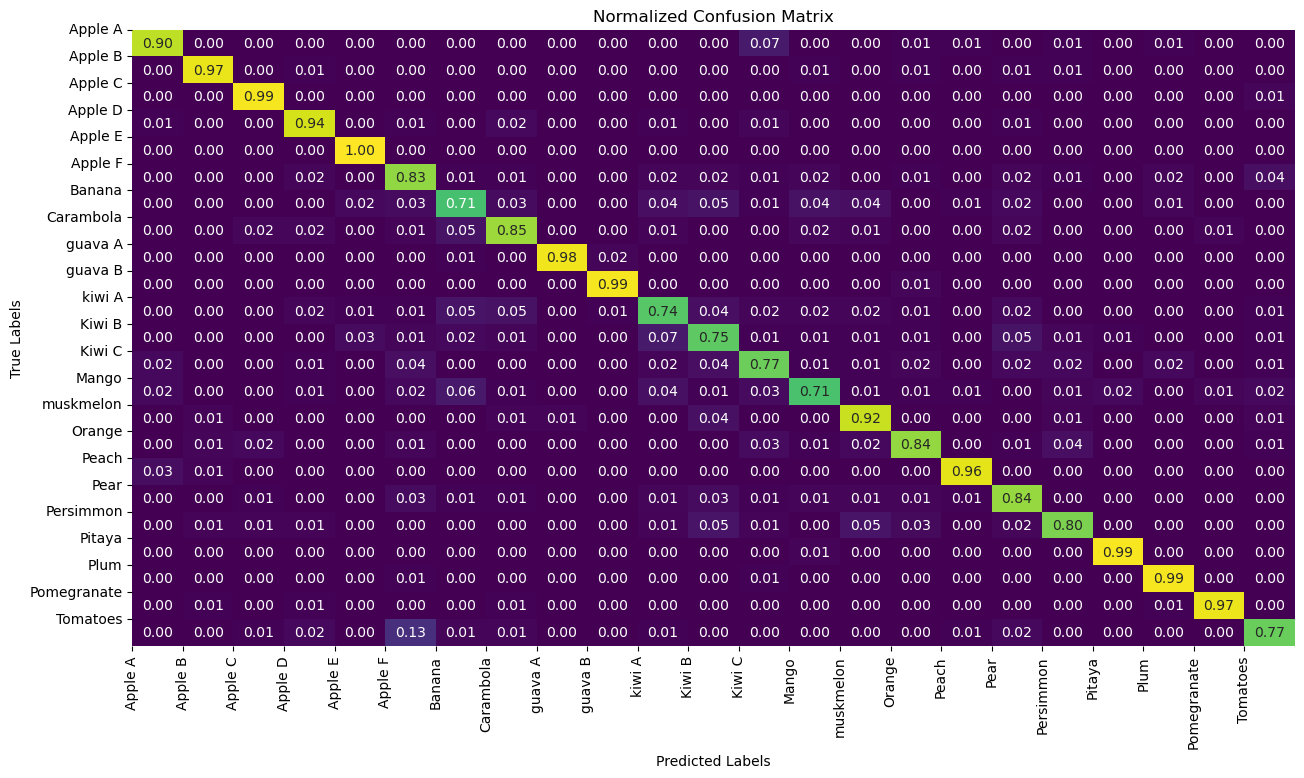

In [49]:
cm = confusion_matrix(y_test_l, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]-
original_labels = df['fruit'].unique()

plt.figure(figsize=(15, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='viridis', cbar=False)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=0)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


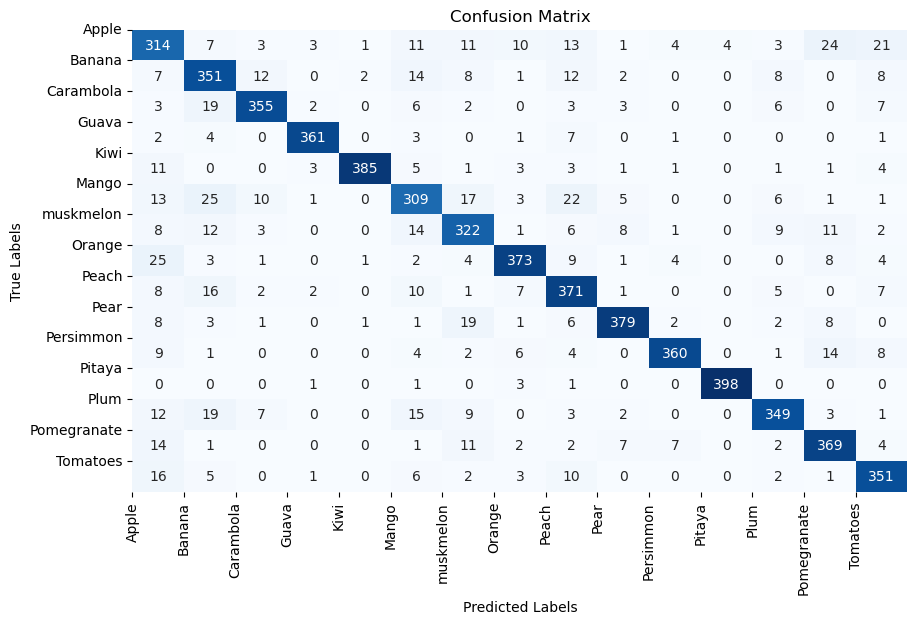

In [14]:
y_pred = lgbm_CV.predict(X_test_pca) 

original_labels = df['fruit'].unique()
cm = confusion_matrix(y_test_l, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# LightGBM con categorias

In [34]:
def get_path(directory, data):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            get_path(folder_path, data)
        else:
            fruit_parts = directory.split("\\")
            fruit_name = fruit_parts[-1]
            data.append((folder_path, fruit_name))

In [35]:
directory = r".\data\archive"
data = []

get_path(directory, data)
df = pd.DataFrame(data, columns=['path', 'fruit'])

In [36]:
df = df[~df['fruit'].str.contains('total', case=False)]
df.reset_index(drop=True, inplace=True)

In [37]:
df['fruit'].value_counts()

fruit
Mango          4154
Banana         3027
Pear           3012
Orange         3012
Peach          2629
Pitaya         2501
Plum           2298
kiwi A         2200
Tomatoes       2171
Pomegranate    2167
Carambola      2080
muskmelon      2078
Persimmon      2072
Apple F        2030
guava B        1626
guava A        1512
Kiwi B         1067
Apple D        1033
Kiwi C         1025
Apple C        1002
Apple B         740
Apple A         692
Apple E         664
Name: count, dtype: int64

In [38]:
min_count = df['fruit'].value_counts().min()
total_samples = min_count * len(df['fruit'].unique())

df_s = pd.DataFrame()

for fruit, count in df['fruit'].value_counts().items():
    sampled_data = df[df['fruit'] == fruit].sample(min_count, random_state=42)
    df_s = pd.concat([df_s, sampled_data])

df_s.reset_index(inplace=True)

In [39]:
print(df_s.shape[0])
df_s['fruit'].value_counts()

15272


fruit
Mango          664
Persimmon      664
Apple A        664
Apple B        664
Apple C        664
Kiwi C         664
Apple D        664
Kiwi B         664
guava A        664
guava B        664
Apple F        664
muskmelon      664
Banana         664
Carambola      664
Pomegranate    664
Tomatoes       664
kiwi A         664
Plum           664
Pitaya         664
Peach          664
Orange         664
Pear           664
Apple E        664
Name: count, dtype: int64

In [40]:
size = (50, 50)
images = [resize(plt.imread(path), size) for path in df_s['path']]

X = np.stack(images)
y = df_s['fruit'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train/255.0
X_test = X_test/255.0

nsamples, nx, ny, nrgb = X_train.shape
X_train = X_train.reshape((nsamples, nx*ny*nrgb))

nsamples, nx, ny, nrgb = X_test.shape
X_test = X_test.reshape((nsamples, nx*ny*nrgb))

le = LabelEncoder()
y_train_l = le.fit_transform(y_train)
y_test_l = le.fit_transform(y_test)

pca = PCA(0.8)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [41]:
lgbm = LGBMClassifier(class_weight='balanced', n_estimators=200, objective='multiclass', 
                      verbose=2).fit(X_train_pca, y_train_l)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000012 seconds, init for row-wise cost 0.003050 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18615
[LightGBM] [Info] Number of data points in the train set: 12217, number of used features: 73
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Tr

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [D

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[Light

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth =

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leav

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 9 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 9 and depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 9 and depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 5
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 6 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with lea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 6 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 6 and depth = 4
[LightGBM] [Warning] No further s

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 7
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 3
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 6 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 13
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 10
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 14 and depth = 6
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 12 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 3 and depth = 2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 17 and depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 1 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 6
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 1 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 6 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 1 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 9 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 3
[LightGBM] [Warning] No fu

In [42]:
round(lgbm.score(X_test_pca, y_test_l), 2)

0.88

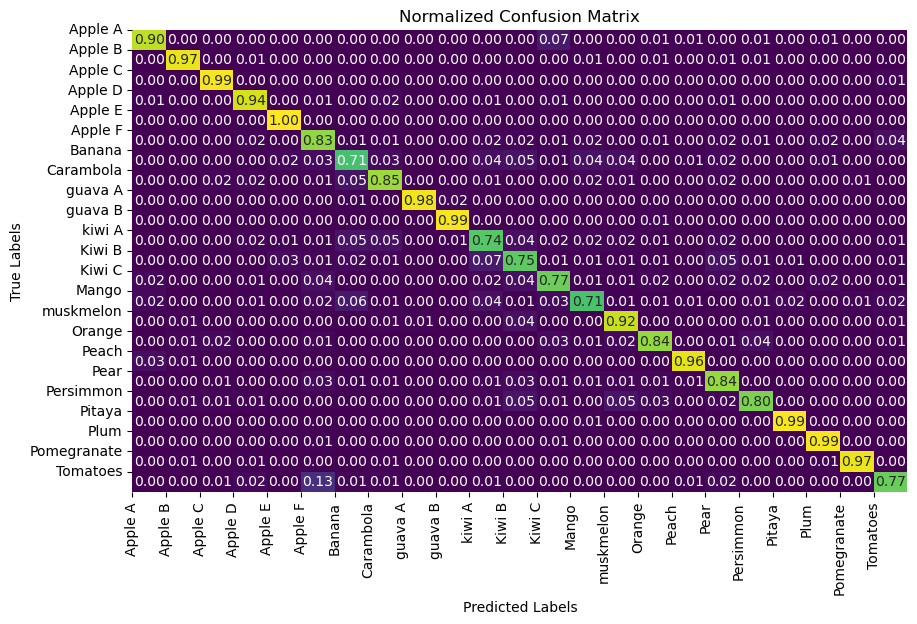

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = lgbm.predict(X_test_pca) 

# Assuming y_test_l and y_pred are defined
cm = confusion_matrix(y_test_l, y_pred)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get original labels
original_labels = df['fruit'].unique()

plt.figure(figsize=(10, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='viridis', cbar=False)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=0)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


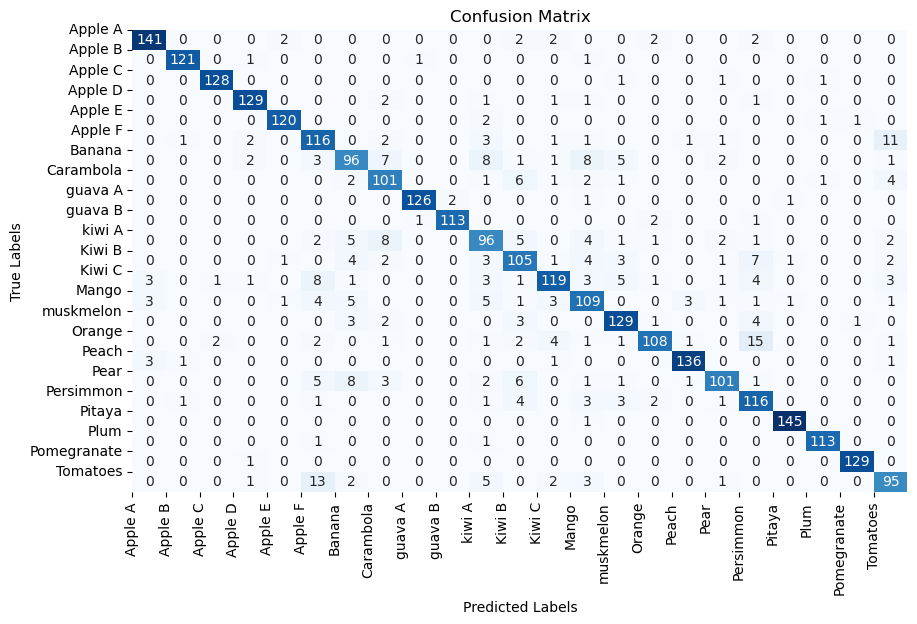

In [74]:
y_pred = lgbm.predict(X_test_pca) 

original_labels = df['fruit'].unique()
cm = confusion_matrix(y_test_l, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=90)
plt.yticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=0)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Comparación de modelos

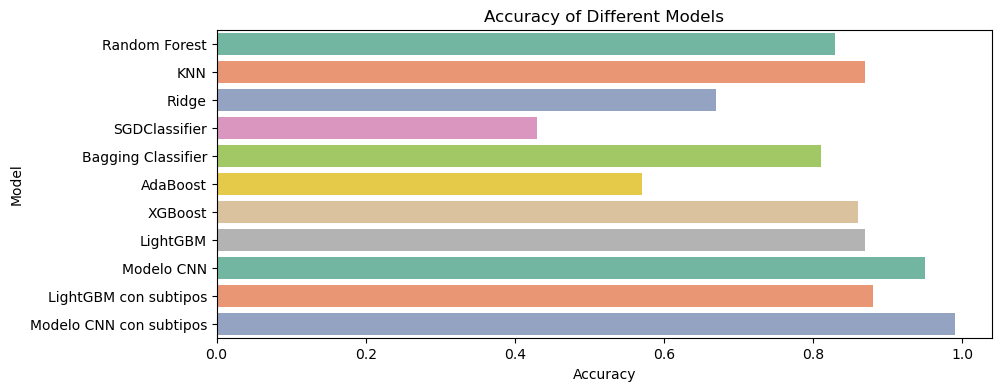

In [3]:
# Como algunos modelos han sido entrenados en diferentes dias,
# vamos a compararlos manualmente, guardamos resultados en un csv
# incluye comparación de modelos de machine learning y deep learning

modelos = pd.read_csv('.\csv\modelos.csv')

plt.figure(figsize=(10, 4))
sns.barplot(modelos, x='accuracy en test', y='modelo', palette='Set2')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Accuracy of Different Models')
plt.show()

# Clasificación por número de lote

Los datos son:
* g: las primeras 5 letras del lote
* proveedosr_id: id del proveedor 

In [5]:
df = pd.read_csv('.\csv\datos_lote.csv')
df['tipo_id'].value_counts()

tipo_id
1     942
4     722
10    181
5     149
6     115
2     113
8     113
13    113
9     110
15    110
14    110
11    109
12    109
3     109
7     109
Name: count, dtype: int64

In [6]:
tipof = {   'Apple':1,
            'Banana':2,
            'Carambola':3,
            'Guava':4,
            'Kiwi':5,
            'Mango':6,
            'muskmelon':7,
            'Orange':8,
            'Peach':9,
            'Pear':10,
            'Persimmon':11,
            'Pitaya':12,
            'Plum':13,
            'Pomegranate':14,
            'Tomatoes':15
}

In [7]:
# Etiquetamos los valores de texto
le1 = LabelEncoder()

df['g_encoded'] = le1.fit_transform(df['g'])

X = df[[ 'g_encoded', 'proveedor_id']]
y = df['tipo_id']

In [9]:
from sklearn.preprocessing import StandardScaler

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Utilizar StandardScaler para estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled

array([[-0.77656771, -0.314955  ],
       [-1.14320344,  1.66923833],
       [-0.78675204, -1.00942266],
       ...,
       [ 1.1279012 ,  1.07398033],
       [ 1.13299336, -0.11653566],
       [ 1.05661092,  1.66923833]])

In [10]:
acc_test_evol = []
rang_n_learners = range(1,20)
for n_learners in rang_n_learners:
    acc_test_run=[]
    clf_RF = RandomForestClassifier(n_learners,max_samples=0.5,max_features=0.5).fit(X_train_scaled, y_train)
    acc =  clf_RF.score(X_test_scaled,y_test)
    print(acc, n_learners)
    acc_test_run.append(acc)
    acc_test_evol.append(np.mean(acc_test_run))

0.8413685847589425 1
0.9097978227060654 2
0.8849144634525661 3
0.9440124416796267 4
0.9502332814930016 5
0.9455676516329704 6
0.9409020217729394 7
0.9548989113530326 8
0.9595645412130638 9
0.9517884914463453 10
0.9611197511664075 11
0.9409020217729394 12
0.9642301710730948 13
0.942457231726283 14
0.9595645412130638 15
0.9502332814930016 16
0.9642301710730948 17
0.9486780715396579 18
0.9517884914463453 19


In [11]:
rang_n_trees=np.arange(1,20)
tuned_parameters = [{'n_estimators': rang_n_trees}]
nfold = 15

# Create Bagging classifier object with CV
clf_bag = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=nfold)

clf_bag.fit(X_train_scaled, y_train)

acc = clf_bag.score(X_test_scaled, y_test)
est =  clf_bag.best_params_['n_estimators']

print(est)

14


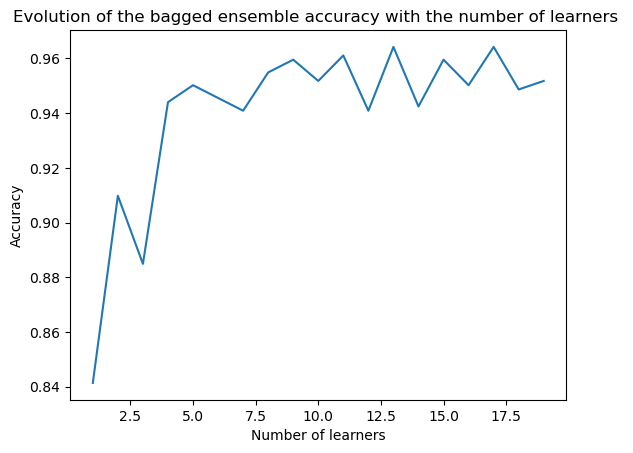

In [12]:
plt.figure()
plt.plot(rang_n_learners,acc_test_evol)
plt.xlabel('Number of learners')
plt.ylabel('Accuracy')
plt.title('Evolution of the bagged ensemble accuracy with the number of learners ')
plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=19, random_state=42)

# Paso 4: Entrenar el modelo
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
pres = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision (PPV): ", pres)
print("Recall (TPR): ", recall)
print("F-1 Score: ", f1)
print("Matthews Correlation Coefficient (MCC): ", mcc)

Accuracy:  0.9580093312597201
Precision (PPV):  0.9595205976119866
Recall (TPR):  0.9580093312597201
F-1 Score:  0.9581483348268968
Matthews Correlation Coefficient (MCC):  0.9498262647114953


In [16]:
arr = {
    "proveedor_id":[5],
    "g":['I65B65S66U76G48L54T57J80T71'[0:6]]
}
df2 = pd.DataFrame(data=arr)

df2['g_encoded'] = le1.transform(df2['g'])

X2 = df2[[ 'g_encoded', 'proveedor_id']]
X_pred = scaler.transform(X2)

In [18]:
y_pred2 = clf.predict(X_pred)
print(y_pred2)
fruta = next(key for key, value in tipof.items() if value == y_pred2[0])
print(fruta)

[3]
Carambola
